# Optimized Kalman Filter: Analysis on MOT20 Database

MOT20 dataset:

https://arxiv.org/pdf/2003.09003.pdf

https://motchallenge.net/data/MOT20/

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats

import os
import pickle as pkl
from collections import Counter
import gc
import cv2

import torch
import torch.nn.functional as F

import utils
import MOT20.MOT_trainer as MOTT
import MOT20.OKF as OKF

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Load MOT20 data

In [3]:
%time dd = MOTT.load_ground_truth()
dd

Wall time: 1.37 s


,dir_id,frame,target,x,y,w,h,flag1,obj_type,visibility,track_start,track_end,unique_id
0,1,1,1,269,947,140,268,1,1,0.83643,True,False,1
1,1,2,1,271,946,140,268,1,1,0.84015,False,False,1
2,1,3,1,273,946,140,268,1,1,0.84015,False,False,1
3,1,4,1,276,946,140,268,1,1,0.84015,False,False,1
4,1,5,1,278,946,140,268,1,1,0.84015,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336915,5,1444,1211,628.5,27.5,55,53,1,1,0.92857,False,False,2332
1336916,5,1445,1211,630.5,26.5,55,51,1,1,0.92857,False,False,2332
1336917,5,1446,1211,631.5,25.5,55,49,1,1,0.92857,False,False,2332
1336918,5,1447,1211,633.5,24.5,55,47,1,1,0.91071,False,False,2332


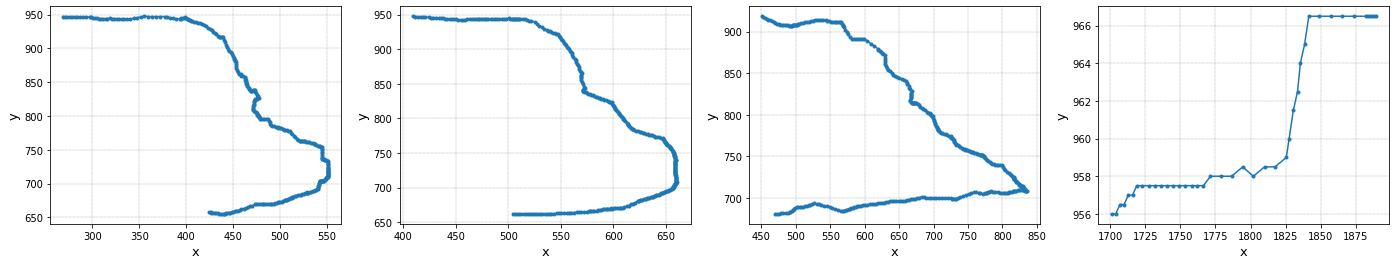

In [4]:
MOTT.plot_targets(dd);

## Split train/test

In [5]:
%%time
dd_train = dd[dd.dir_id<=3].reset_index(drop=True)
dd_test  = dd[dd.dir_id> 3].reset_index(drop=True)
Xtrain, Ytrain = MOTT.get_trainable_data(dd_train)
Xtest, Ytest = MOTT.get_trainable_data(dd_test)
len(Ytrain), Ytrain[0].shape

Wall time: 1.38 s


(1117, (338, 6))

# Create models

In [6]:
model_args = dict(dim_x=6, dim_z=4, F=MOTT.get_F(), H=MOTT.get_H(), z2x=MOTT.z2x, loss_fun=MOTT.loss)
models = [
    OKF.OKF(title='KF', optimize=False, **model_args),
    OKF.OKF(title='OKF', optimize=True, **model_args)
]

# Train

Note - possible things to modify:
- sparser data (subsample>1) - so that motion & prediction are less trivial.
- splitting train/test per target instead of per folder (easier generalization). alternatively, split train/valid per folder (so that validation isn't biased towards training).

In [199]:
%%time
r1, rv1 = OKF.train(models[0], Xtrain, Ytrain)
rv1

Wall time: 35.3 s


,model,target,t,SE,AE,loss
0,KF,0,0,0.000000,0.000000,0.000000
1,KF,0,1,3.250000,1.802776,3.250000
2,KF,0,2,1.010496,1.005234,1.010496
3,KF,0,3,0.080678,0.284038,0.080678
4,KF,0,4,0.008024,0.089577,0.008024
...,...,...,...,...,...,...
89148,KF,167,522,0.139295,0.373223,0.139295
89149,KF,167,523,0.138132,0.371661,0.138132
89150,KF,167,524,1.134024,1.064906,1.134024
89151,KF,167,525,0.634283,0.796419,0.634283


In [210]:
%%time
r2, rv2 = OKF.train(models[1], Xtrain, Ytrain)
r2


Training OKF:
samples=949(t)+168(v)=1117; batch_size=10; iterations=1(e)x94(b)=94.
	[OKF] 01.0001/01.0094:	train_RMSE=0.77, valid_RMSE=0.71   |   43 [s]
	[OKF] 01.0031/01.0094:	train_RMSE=0.56, valid_RMSE=0.65   |   250 [s]
	[OKF] 01.0061/01.0094:	train_RMSE=0.67, valid_RMSE=0.64   |   450 [s]
	[OKF] 01.0091/01.0094:	train_RMSE=0.64, valid_RMSE=0.64   |   642 [s]
	[OKF] 01.0094/01.0094:	train_RMSE=0.79, valid_RMSE=0.64   |   690 [s]
[OKF] Epoch 1/1 (690 [s])
[OKF] Training done (690 [s])
	best valid loss: 0;	no early stopping:	1 epochs, 94 batches, 94 total iterations.
Wall time: 12min 7s


,model,t,group,loss,RMSE
0,OKF,1,train,0.594006,0.770718
1,OKF,2,train,0.528930,0.727276
2,OKF,3,train,0.638883,0.799302
3,OKF,4,train,0.629127,0.793175
4,OKF,5,train,0.504633,0.710375
...,...,...,...,...,...
0,OKF,1,valid,0.510339,0.714380
1,OKF,31,valid,0.418838,0.647177
2,OKF,61,valid,0.415606,0.644675
3,OKF,91,valid,0.415782,0.644811


### Training summary (OKF only):

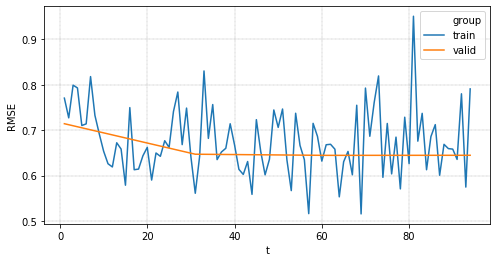

In [218]:
ax = utils.Axes(1, 1, axsize=(8,4))[0]
sns.lineplot(data=r2, x='t', hue='group', y='RMSE', ax=ax)

### Validation summary:

In [282]:
rv = pd.concat((rv1,rv2))
rv = rv[rv.t>0]
print('Average losses:')
print(rv.groupby('model').apply(lambda d:d.loss.mean()))
rv

Average losses:
model
KF     0.521440
OKF    0.416391
dtype: float64


,model,target,t,SE,AE,loss
1,KF,0,1,3.250000,1.802776,3.250000
2,KF,0,2,1.010496,1.005234,1.010496
3,KF,0,3,0.080678,0.284038,0.080678
4,KF,0,4,0.008024,0.089577,0.008024
5,KF,0,5,0.000959,0.030968,0.000959
...,...,...,...,...,...,...
89148,OKF,167,522,0.120092,0.346542,0.120092
89149,OKF,167,523,0.081791,0.285992,0.081791
89150,OKF,167,524,0.887876,0.942272,0.887876
89151,OKF,167,525,0.251221,0.501220,0.251221


Wall time: 9.03 s


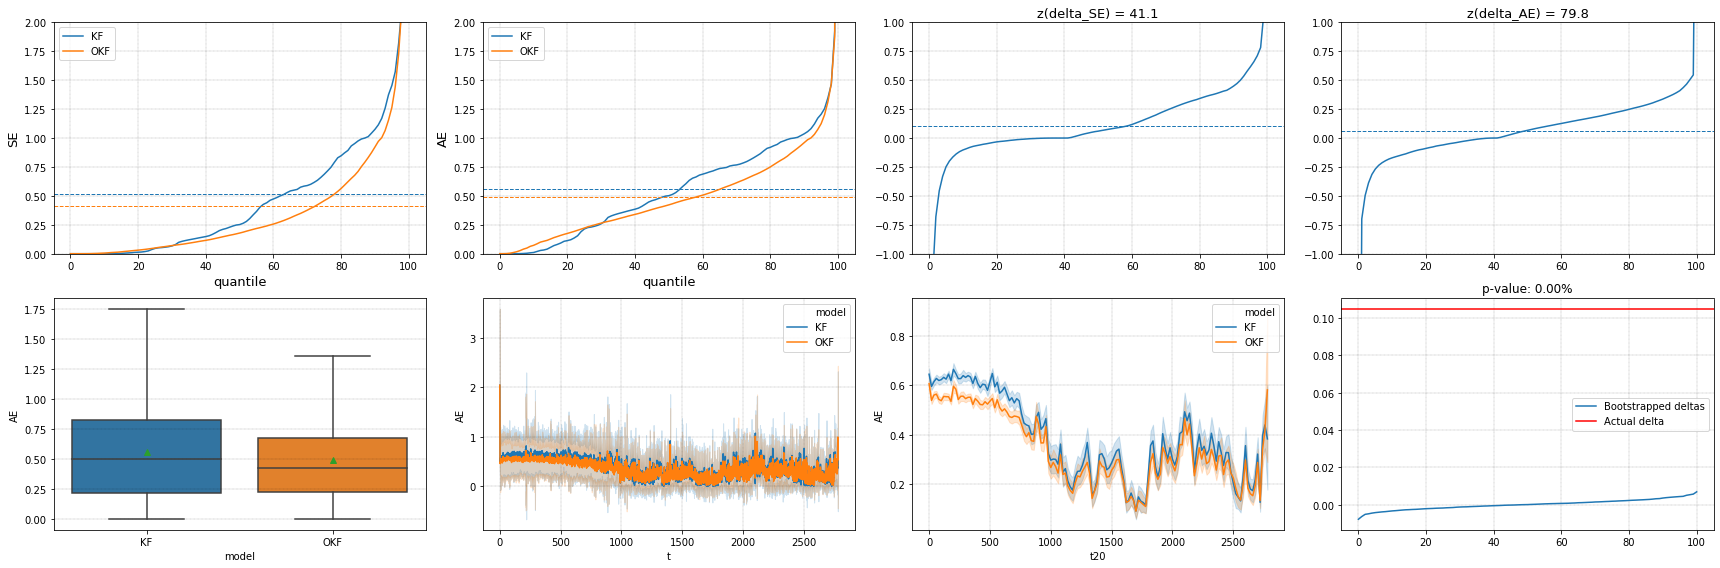

In [283]:
%%time
axs = utils.Axes(8,4,axsize=(6,4))
a = 0

utils.plot_quantiles(rv1.SE.values, showmeans=True, ax=axs[a], label='KF');
utils.plot_quantiles(rv2.SE.values, showmeans=True, ax=axs[a], label='OKF');
axs[a].legend()
axs[a].set_ylim((0,2))
axs.labs(a, 'quantile', 'SE')
a += 1

utils.plot_quantiles(rv1.AE.values, showmeans=True, ax=axs[a], label='KF');
utils.plot_quantiles(rv2.AE.values, showmeans=True, ax=axs[a], label='OKF');
axs[a].legend()
axs[a].set_ylim((0,2))
axs.labs(a, 'quantile', 'AE')
a += 1

delta = rv1.loss.values-rv2.loss.values
utils.plot_quantiles(delta, showmeans=True, ax=axs[a]);
axs[a].set_ylim((-1,1))
axs.labs(a, title=f'z(delta_SE) = {np.mean(delta)/np.std(delta)*np.sqrt(len(delta)):.1f}')
a += 1

delta = rv1.AE.values-rv2.AE.values
utils.plot_quantiles(delta, showmeans=True, ax=axs[a]);
axs[a].set_ylim((-1,1))
axs.labs(a, title=f'z(delta_AE) = {np.mean(delta)/np.std(delta)*np.sqrt(len(delta)):.1f}')
a += 1

sns.boxplot(data=rv, x='model', y='AE', showmeans=True, showfliers=False, ax=axs[a])
a += 1

sns.lineplot(data=rv, x='t', hue='model', y='AE', ci='sd', ax=axs[a]);
a += 1

rv['t20'] = rv.t.values//20 * 20
sns.lineplot(data=rv, x='t20', hue='model', y='AE', ax=axs[a]);
a += 1

B = 1000
ax = axs[a]
delta = rv1.loss.values-rv2.loss.values
mean0 = np.mean(delta)
means = [np.mean(np.sign(np.random.rand(len(delta))-0.5) * delta) for _ in range(B)]
pval = np.mean(means>=mean0)
utils.plot_quantiles(means, label='Bootstrapped deltas', ax=ax)
ax.axhline(mean0, color='r', label='Actual delta')
ax.legend()
ax.set_title(f'p-value: {100*pval:.2f}%')
a += 1

plt.tight_layout();

### Q & R comparison:

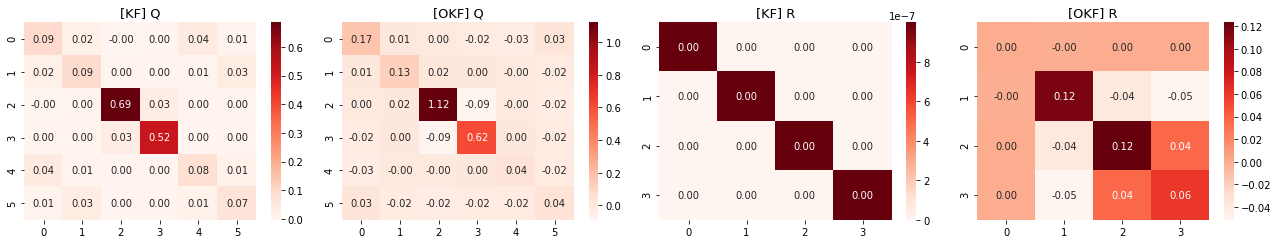

In [309]:
axs = utils.Axes(2*len(models),4,axsize=(4.5,3.5))
a = 0
for m in models:
    tit = m.title
    Q = m.get_SPD(m.Q_D, m.Q_L).detach().numpy()
    R = m.get_SPD(m.R_D, m.R_L).detach().numpy()
    sns.heatmap(Q, annot=True, fmt='.2f', cmap="Reds", ax=axs[a])
    sns.heatmap(R, annot=True, fmt='.2f', cmap="Reds", ax=axs[a+len(models)])
    axs.labs(a, title=f'[{tit}] Q')
    axs.labs(a+len(models), title=f'[{tit}] R')
    a += 1

plt.tight_layout();

Checklist:
1. (V) make sure training runs fine.
2. (V) observe results.
3. (V) modify batch_size & n_epochs as needed, and possibly step size etc., until training converges (no underfit nor overfit).
4. (V) compare noise matrices and prediction errors between KF & OKF.

# Test

In [7]:
for m in models:
    m.load_model()

In [26]:
%%time
rt = pd.DataFrame()
for m in models:
    rt = pd.concat((rt, OKF.test_model(m, Xtest, Ytest, detailed=True)))
rt = rt[rt.t>0]
rt

Wall time: 10min 29s


,model,target,t,SE,AE,loss
1,KF,0,1,2.000000,1.414214,2.000000
2,KF,0,2,0.000144,0.011992,0.000144
3,KF,0,3,0.988550,0.994258,0.988550
4,KF,0,4,0.437038,0.661088,0.437038
5,KF,0,5,0.586574,0.765881,0.586574
...,...,...,...,...,...,...
751322,OKF,1207,442,0.254130,0.504113,0.254130
751323,OKF,1207,443,0.487628,0.698304,0.487628
751324,OKF,1207,444,0.325601,0.570615,0.325601
751325,OKF,1207,445,0.408698,0.639295,0.408698


In [8]:
# rt.to_pickle('data/MOT20_results.pkl')
rt = pd.read_pickle('data/MOT20_results.pkl')

Wall time: 23.2 s


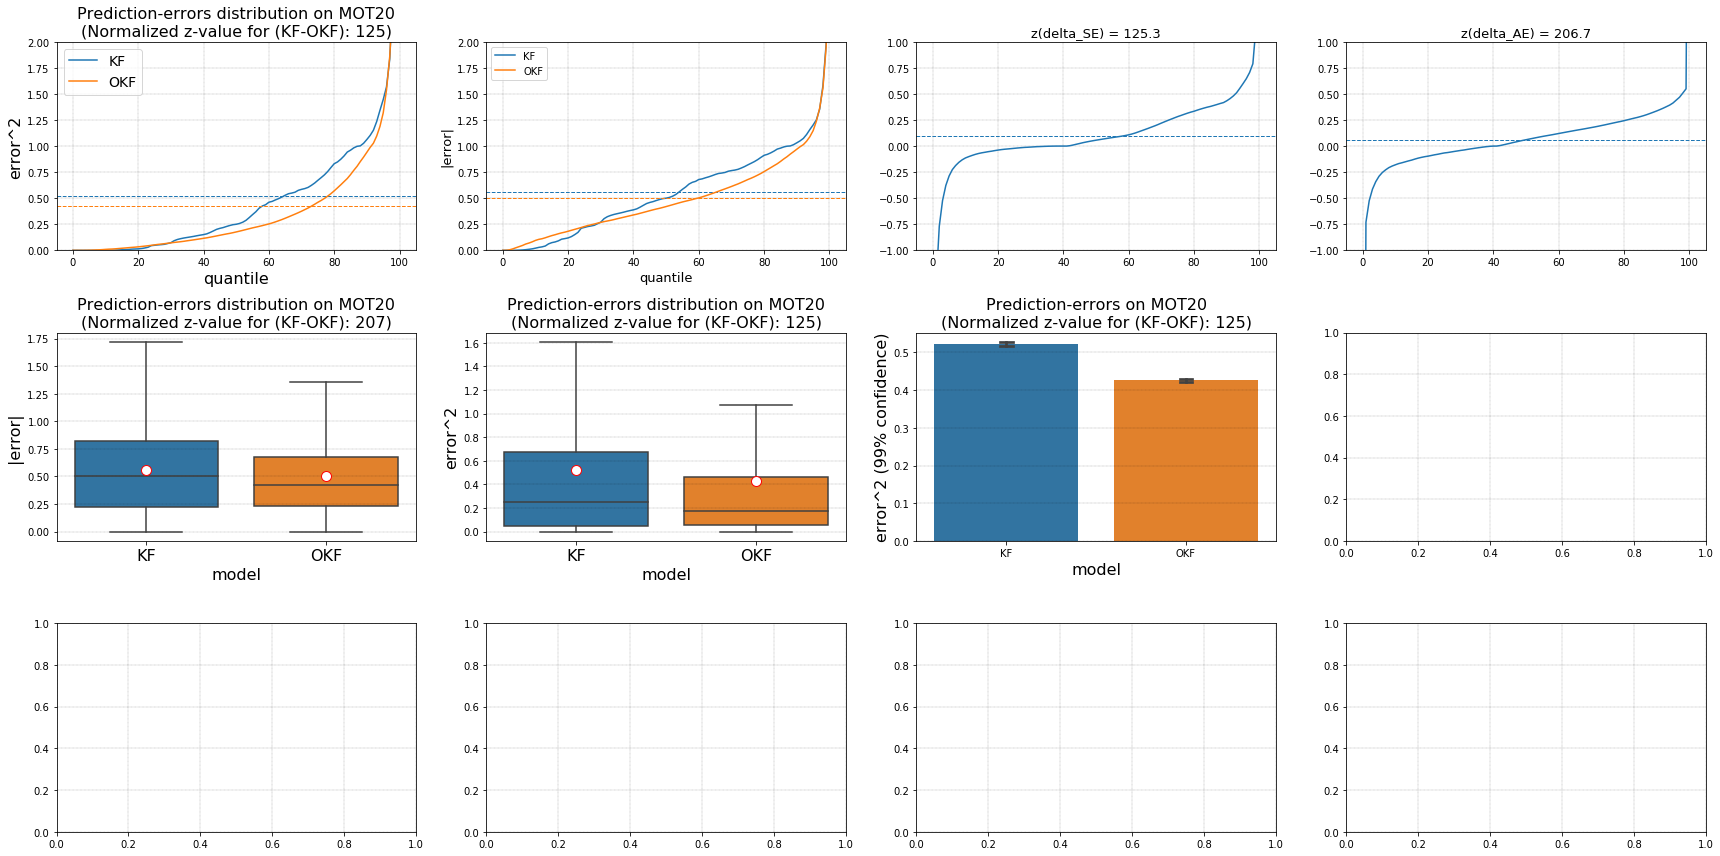

In [16]:
%%time
DETAILED = False
rt1 = rt[rt.model=='KF']
rt2 = rt[rt.model=='OKF']
axs = utils.Axes(12,4,axsize=(6,4))
a = 0

utils.plot_quantiles(rt1.SE.values, showmeans=True, ax=axs[a], label='KF');
utils.plot_quantiles(rt2.SE.values, showmeans=True, ax=axs[a], label='OKF');
axs[a].legend(fontsize=14)
axs[a].set_ylim((0,2))
delta = rt1.SE.values-rt2.SE.values
z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
axs.labs(a, 'quantile', 'error^2', f'Prediction-errors distribution on MOT20\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
# print(rt2.SE.values.mean()/rt1.SE.values.mean())
a += 1

utils.plot_quantiles(rt1.AE.values, showmeans=True, ax=axs[a], label='KF');
utils.plot_quantiles(rt2.AE.values, showmeans=True, ax=axs[a], label='OKF');
axs[a].legend()
axs[a].set_ylim((0,2))
axs.labs(a, 'quantile', '|error|')
a += 1

delta = rt1.loss.values-rt2.loss.values
utils.plot_quantiles(delta, showmeans=True, ax=axs[a]);
axs[a].set_ylim((-1,1))
axs.labs(a, title=f'z(delta_SE) = {np.mean(delta)/np.std(delta)*np.sqrt(len(delta)):.1f}')
a += 1

delta = rt1.AE.values-rt2.AE.values
utils.plot_quantiles(delta, showmeans=True, ax=axs[a]);
axs[a].set_ylim((-1,1))
axs.labs(a, title=f'z(delta_AE) = {np.mean(delta)/np.std(delta)*np.sqrt(len(delta)):.1f}')
a += 1

sns.boxplot(data=rt, x='model', y='AE', showmeans=True, showfliers=False, ax=axs[a], meanprops=dict(marker='o',markerfacecolor='w',markeredgecolor='r',markersize=10))
delta = rt1.AE.values-rt2.AE.values
z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
p = stats.norm.sf(z)
axs.labs(a, 'model', '|error|', f'Prediction-errors distribution on MOT20\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=16)
a += 1

sns.boxplot(data=rt, x='model', y='SE', showmeans=True, showfliers=False, ax=axs[a], meanprops=dict(marker='o',markerfacecolor='w',markeredgecolor='r',markersize=10))
delta = rt1.loss.values-rt2.loss.values
z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
p = stats.norm.sf(z)
axs.labs(a, 'model', 'error^2', f'Prediction-errors distribution on MOT20\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=16)
a += 1

sns.barplot(data=rt, x='model', y='loss', capsize=.07, ci=99, ax=axs[a])
axs.labs(a, 'model', 'error^2 (99% confidence)', f'Prediction-errors on MOT20\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
a += 1

if DETAILED:

    sns.violinplot(data=rt, x='model', y='AE', showmeans=True, showfliers=False, ax=axs[a])
    delta = rt1.AE.values-rt2.AE.values
    z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
    p = stats.norm.sf(z)
    axs.labs(a, 'model', '|error|', f'Prediction-errors distribution on MOT20\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
    axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=16)
    axs[a].set_ylim((0,3))
    a += 1

    sns.violinplot(data=rt, x='model', y='SE', showmeans=True, showfliers=False, ax=axs[a])
    delta = rt1.loss.values-rt2.loss.values
    z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
    p = stats.norm.sf(z)
    axs.labs(a, 'model', 'error^2', f'Prediction-errors distribution on MOT20\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=16)
    axs[a].set_xticklabels(axs[a].get_xticklabels(), fontsize=16)
    axs[a].set_ylim((0,3))
    a += 1
    
    sns.lineplot(data=rt, x='t', hue='model', y='AE', ci='sd', ax=axs[a]);
    a += 1

    rt['t20'] = rt.t.values//20 * 20
    sns.lineplot(data=rt, x='t20', hue='model', y='AE', ax=axs[a]);
    a += 1

    B = 1000
    ax = axs[a]
    delta = rt1.loss.values-rt2.loss.values
    mean0 = np.mean(delta)
    means = [np.mean(np.sign(np.random.rand(len(delta))-0.5) * delta) for _ in range(B)]
    pval = np.mean(means>=mean0)
    utils.plot_quantiles(means, label='Bootstrapped deltas', ax=ax)
    ax.axhline(mean0, color='r', label='Actual delta')
    ax.legend()
    ax.set_title(f'p-value: {100*pval:.2f}%')
    a += 1

plt.tight_layout();

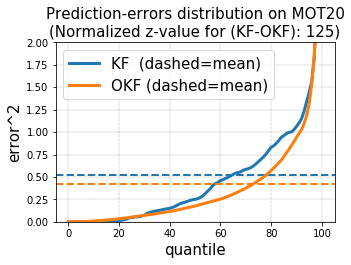

In [27]:
axs = utils.Axes(1,1,axsize=(5,3.3))
utils.plot_quantiles(rt1.SE.values, showmeans=True, ax=axs[a], label='KF  (dashed=mean)', linewidth=3, means_args=dict(linewidth=2));
utils.plot_quantiles(rt2.SE.values, showmeans=True, ax=axs[a], label='OKF (dashed=mean)', linewidth=3, means_args=dict(linewidth=2));
axs[a].legend(fontsize=15)
axs[a].set_ylim((0,2))
delta = rt1.SE.values-rt2.SE.values
z = np.mean(delta)/np.std(delta)*np.sqrt(len(delta))
axs.labs(a, 'quantile', 'error^2', f'Prediction-errors distribution on MOT20\n(Normalized z-value for (KF-OKF): {z:.0f})', fontsize=15)
plt.savefig('MOT20_SE.png', bbox_inches='tight')

In [11]:
100*(1-rt2.loss.mean()/rt1.loss.mean())

18.298826347034524

### Tracking visualization

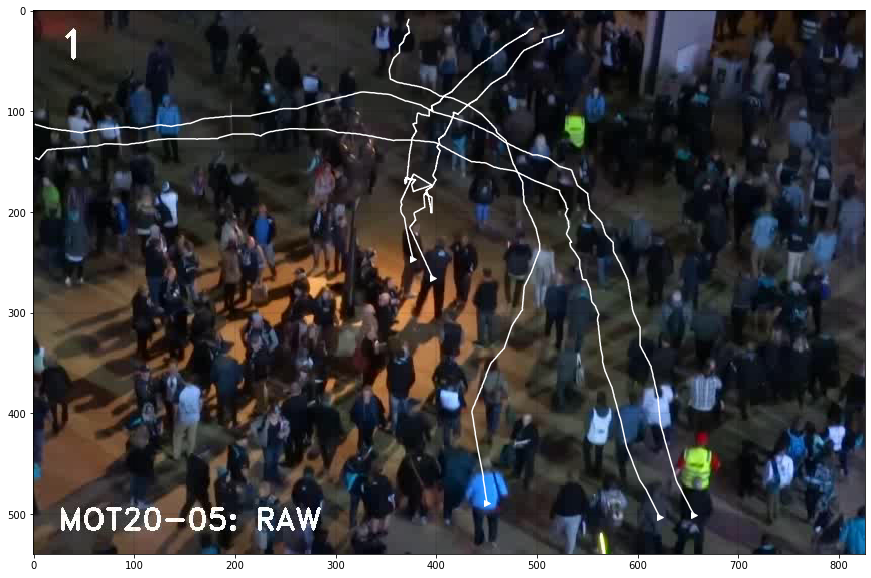

In [437]:
axs = utils.Axes(1,1,axsize=(16,10))
ax = axs[0]
ax.imshow(frame)
for itar in targets_from_start[:5]:
    ax.plot(Ytest[itar][:,0]/2,Ytest[itar][:,1]/2,'w-')#, linewidth=3)
    ax.plot(Ytest[itar][:1,0]/2,Ytest[itar][:1,1]/2,'w>',markersize=6)

In [396]:
dtest = dd[dd.dir_id==5]
targets_from_start = (dtest[dtest.frame==1].target - 1).values
targets_from_start

array([43, 58, 109, 110, 122, 123, 126, 127, 128, 132, 133, 134, 135, 136, 137, 138, 139, 156, 157, 162, 163, 165, 168, 169, 170, 171, 183, 187, 190,
       192, 193, 194, 195, 196, 199, 200, 217, 218, 222, 223, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241,
       242, 243, 244, 245, 246, 247, 248, 249, 250, 267, 268, 269, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 284, 285, 286, 287,
       288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
       317, 319, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346,
       347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374,
       375, 376, 377, 378, 379, 380, 381, 382, 383, 401, 423, 424, 426, 432, 511, 512, 533, 534, 535, 553, 554, 556

109 model
KF     0.839301
OKF    0.860563
dtype: float64
110 model
KF     0.710250
OKF    0.603133
dtype: float64
Wall time: 603 ms


(0, 825.5)

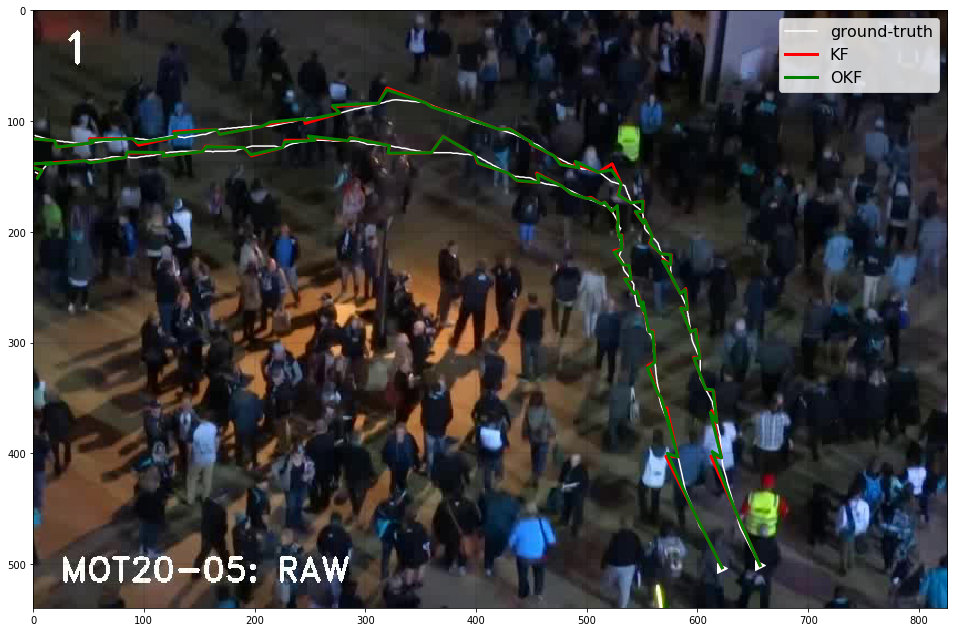

In [445]:
%%time
cap = cv2.VideoCapture(MOTT.MOT20_PATH+'MOT20-05-raw.webm')
ret, frame = cap.read()
frame = frame[:,:,::-1]

axs = utils.Axes(1,1,axsize=(19,11))
ax = axs[0]
ax.imshow(frame)
colors = ['r','g']
preds = {}
for itar in targets_from_start[2:4]:
    print(itar, rt[rt.target==itar].groupby('model').apply(lambda d:d.loss.mean()))
    preds[itar] = []
    XX = Xtest[itar]
    ax.plot(Ytest[itar][:,0]/2,Ytest[itar][:,1]/2,'w-', label='ground-truth' if itar==targets_from_start[2] else None)
    ax.plot(Ytest[itar][:1,0]/2,Ytest[itar][:1,1]/2,'w>',markersize=10)
    for i,m in enumerate(models):
        preds[itar].append([])
        m.init_state()
        for t in range(len(XX)):
            x = XX[t,:]
            m.predict()
            if t>0:
                preds[itar][i].append(m.x.detach().numpy())
            if (t%20)==0:
                m.update(x)
        preds[itar][i] = np.stack(preds[itar][i])
        ax.plot(preds[itar][i][:,0]/2, preds[itar][i][:,1]/2, colors[i], linewidth=3, label=f'{m.title}' if itar==targets_from_start[2] else None)
ax.legend(fontsize=16)
ax.set_xlim((0,None))
# ax.set_xlim((360,410))
# ax.set_ylim((270,150))